# Simulation of star PSF curve and Test optimization function

- author : Sylvie Dagoret-Campagne
- afflilation : LAL-CNRS
- creation date : December 13th 2019
- update :December 15th 2019



In [67]:
import os
import re
import numpy as np

In [68]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') # vary depending on your lang/locale

'en_US.UTF-8'

In [69]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [70]:
import numpy as np
import re
import time
from datetime import datetime,date
import dateutil.parser
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import Table

In [71]:
from math import ceil,floor
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval,PercentileInterval,SqrtStretch,LogStretch)
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.modeling.functional_models import Moffat2D

In [72]:
from numpy.core._multiarray_umath import ndarray
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

In [73]:
from scipy import interpolate

In [74]:
from scipy import optimize
from scipy.optimize import minimize

In [75]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(10,10)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

# Definitions

## Addition includes

In [76]:
import sys
sys.path.append("../..")
sys.path.append("../../FeaturesExtractor")
sys.path.append("../../FeaturesExtractor/features")

In [77]:
from FeaturesExtractor.config import set_logger
from FeaturesExtractor.tools import *
from FeaturesExtractor import parameters

## Function

# Configuration

In [78]:
IMAGE_SIZE=50

In [79]:
THETA=45.*np.pi/180.

In [80]:
SIGMA_X=10
#SIGMA_Y=10
SIGMA_Y=6

In [81]:
X0=IMAGE_SIZE/2
Y0=IMAGE_SIZE/2

In [82]:
a=0.5*((np.cos(THETA)/SIGMA_X)**2+(np.sin(THETA)/SIGMA_Y)**2)

In [83]:
b=-np.sin(2*THETA)/4.*(-1./SIGMA_X**2 + 1./SIGMA_Y**2)

In [84]:
c=0.5*((np.sin(THETA)/SIGMA_X)**2+(np.cos(THETA)/SIGMA_Y)**2)

In [85]:
A=1000.

In [86]:
#sat_fraction=0   # no saturation
sat_fraction=0.6  # saturation

In [87]:
FLAG_MOFFAT2D=False

In [88]:
ALPHA=-1         # exponent of the Moffat

In [89]:
if FLAG_MOFFAT2D:
    psf_title="psf : moffat, "
else:
    psf_title="psf : gaussian, "

In [90]:
def PSF(x,y):
    if FLAG_MOFFAT2D:
        M=A* np.power(1+ a*(x-X0)**2 + 2*b*(y-Y0)*(x-X0) +c*(y-Y0)**2,ALPHA)
    else:
        M=A*np.exp(-(a*(x-X0)**2 + 2*b*(y-Y0)*(x-X0) + c*(y-Y0)**2))
        
        
    if sat_fraction==0:
        return M
    else:
        Smax=sat_fraction*A
        S=np.where(M<Smax,M,Smax)
        return S

# Start

In [91]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

# Generate the image

## Background

In [92]:
background=np.random.normal(0,10,(IMAGE_SIZE,IMAGE_SIZE))

In [93]:
background-=background.min()

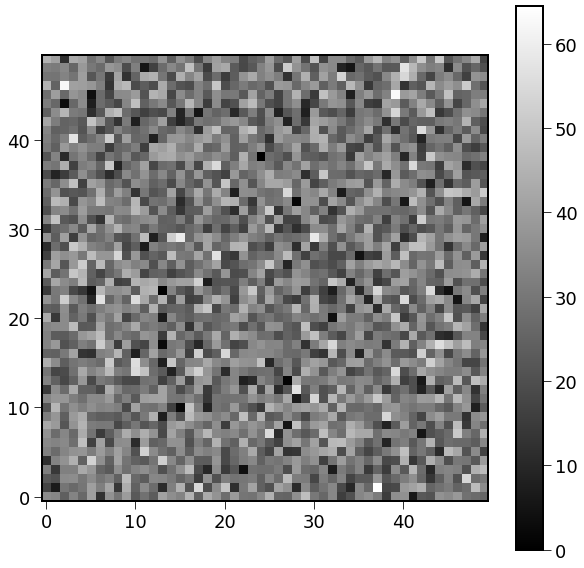

In [94]:
im=plt.imshow(background,origin="lower",cmap="gray")
plt.colorbar(im)

## Signal

In [95]:
X=np.arange(IMAGE_SIZE)
Y=np.arange(IMAGE_SIZE)

In [96]:
XX, YY = np.meshgrid(X, Y)

In [97]:
signal=PSF(XX,YY)

In [98]:
image=signal+background

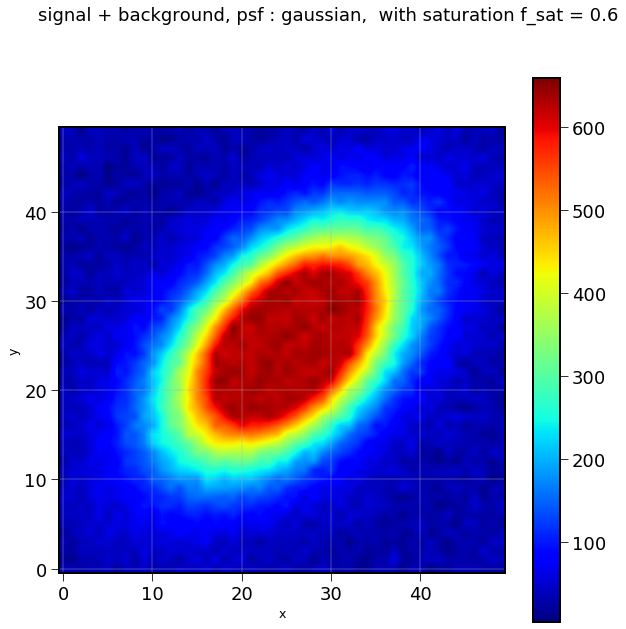

In [99]:
im=plt.imshow(image,origin="lower",interpolation='bilinear',cmap="jet")
plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')
title = "signal + background, " + psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title)
plt.grid()

Text(0.5, 0.98, 'Signal + background , psf : gaussian,  with saturation f_sat = 0.6')

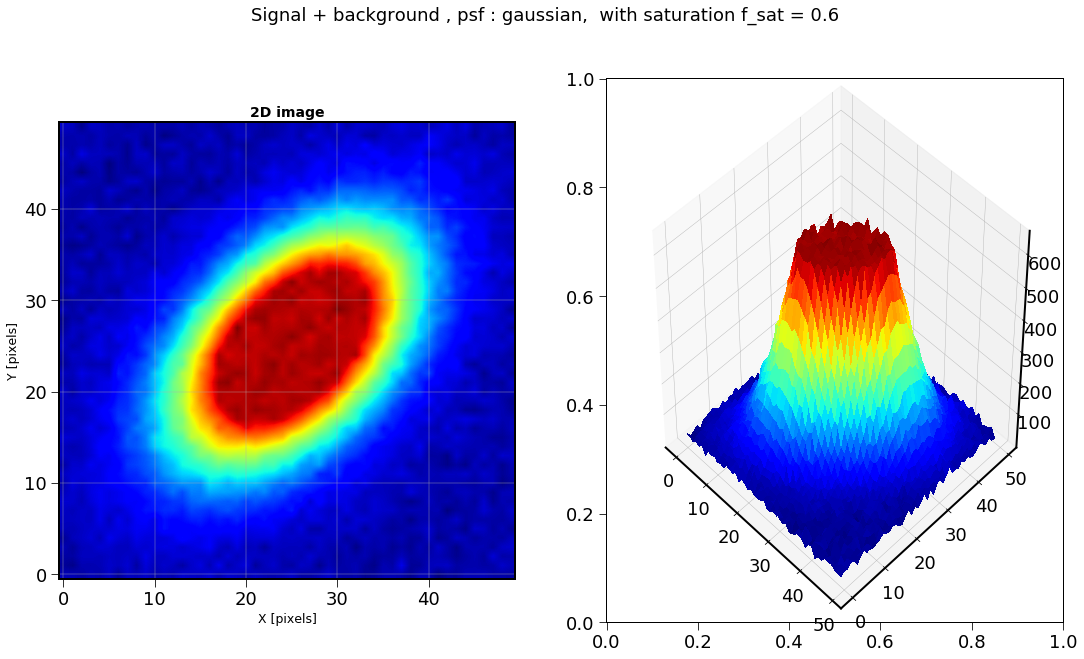

In [100]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(image, origin="lower", interpolation='bilinear',cmap=plt.cm.jet)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(45, -45)
ax2.plot_surface(XX, YY, image,rstride=1, cstride=1 ,antialiased=False,cmap=plt.cm.jet)
        

# fig.tight_layout()
title = "Signal + background , "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title,fontsize=18)


Text(0.5, 0.98, 'signal + background, psf : gaussian,  with saturation f_sat = 0.6')

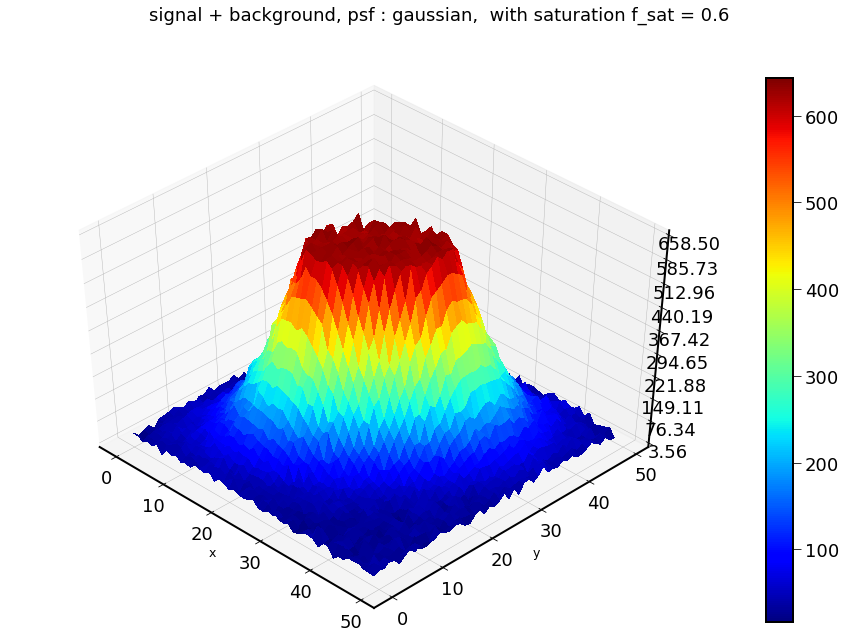

In [101]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
surf=ax.plot_surface(XX, YY, image, cmap="jet", rstride=1, cstride=1 ,antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#fig.colorbar(surf, shrink=0.5, aspect=5)
fig.colorbar(surf)




title = "signal + background, "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title)

# Compute the Hessian

In [102]:
lambda_plus, lambda_minus, theta = hessian_and_theta(image,margin_cut=1)

In [103]:
Nx=lambda_plus.shape[1]
Ny=lambda_plus.shape[0]

In [104]:
PadX=int((IMAGE_SIZE-Nx)/2)
PadY=int((IMAGE_SIZE-Ny)/2)

In [105]:
lambda_plus_new=np.zeros((IMAGE_SIZE,IMAGE_SIZE))
lambda_minus_new=np.zeros((IMAGE_SIZE,IMAGE_SIZE))

In [106]:
lambda_plus_new[PadY:IMAGE_SIZE-PadY, PadX:IMAGE_SIZE-PadX]= lambda_plus
lambda_minus_new[PadY:IMAGE_SIZE-PadY, PadX:IMAGE_SIZE-PadX]= lambda_minus

Text(0.5, 0.98, 'Lambda_plus, psf : gaussian,  with saturation f_sat = 0.6')

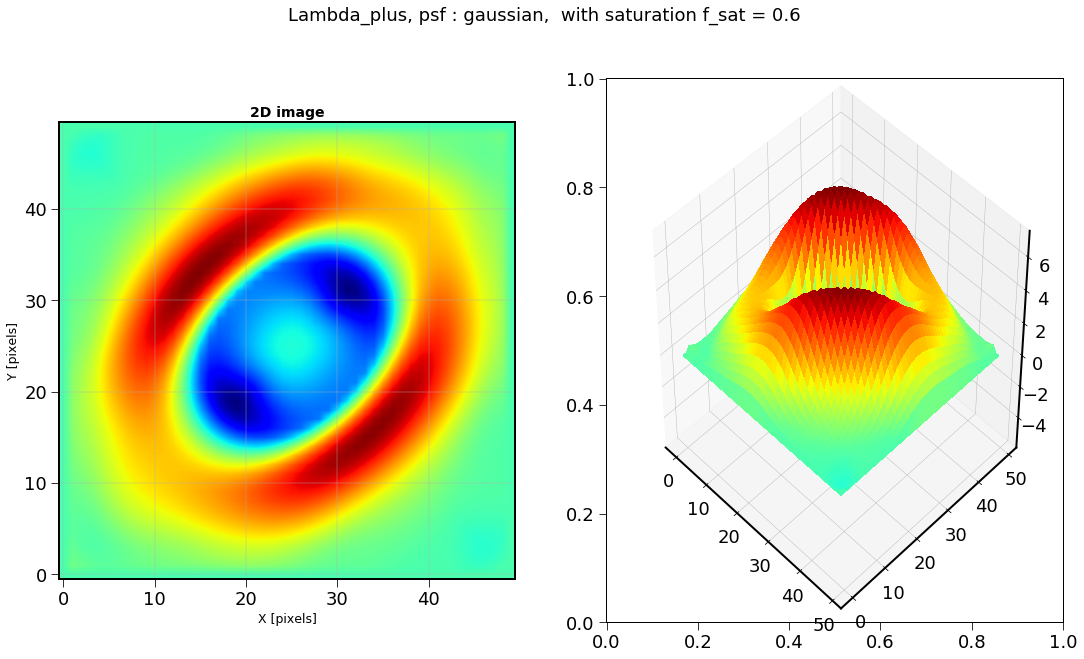

In [107]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_plus_new, origin="lower", interpolation='bilinear',cmap=plt.cm.jet)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(45, -45)
ax2.plot_surface(XX, YY, lambda_plus_new,rstride=1, cstride=1 ,antialiased=False,cmap=plt.cm.jet)
        

# fig.tight_layout()
title = "Lambda_plus, "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title,fontsize=18)


Text(0.5, 0.98, 'Lambda_minus, psf : gaussian,  with saturation f_sat = 0.6')

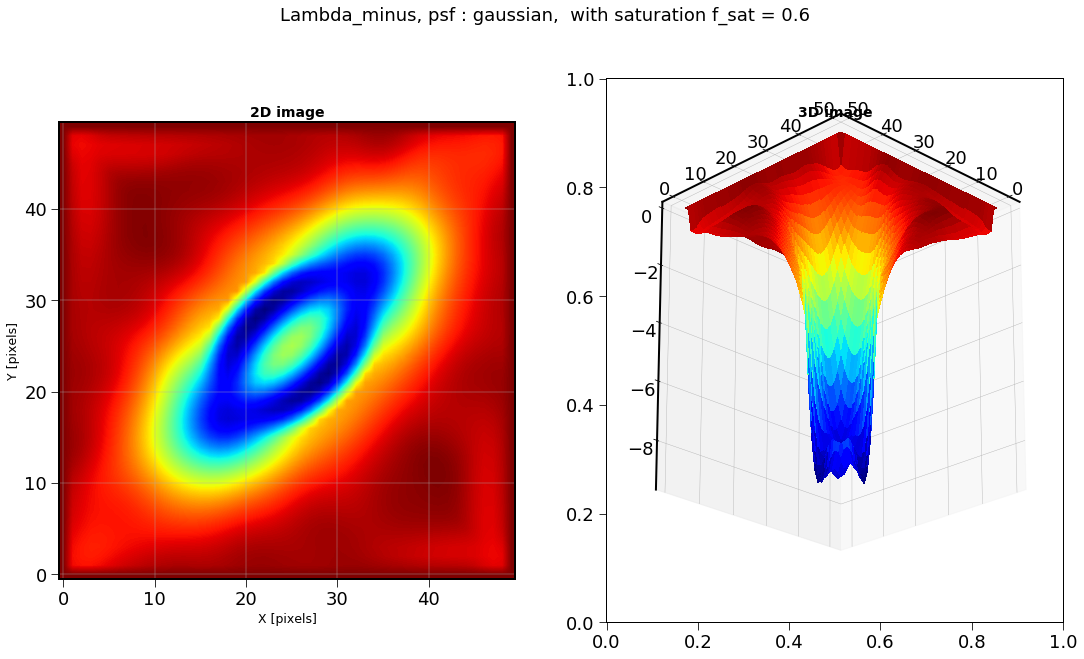

In [108]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_minus_new, origin="lower", interpolation='bilinear',cmap=plt.cm.jet)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('3D image', fontsize=14)
ax2.view_init(-20, 45)
ax2.plot_surface(XX, YY, lambda_minus_new, rstride=1,  cstride=1 ,antialiased=False,cmap=plt.cm.jet)
        
title = "Lambda_minus, "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title,fontsize=18)

# detect the edges

In [109]:
lambda_plus_edge=feature.canny(lambda_plus_new, sigma=5)
lambda_minus_edge=feature.canny(lambda_minus_new, sigma=5)

Text(0.5, 0.98, 'Canny edge detection, psf : gaussian,  with saturation f_sat = 0.6')

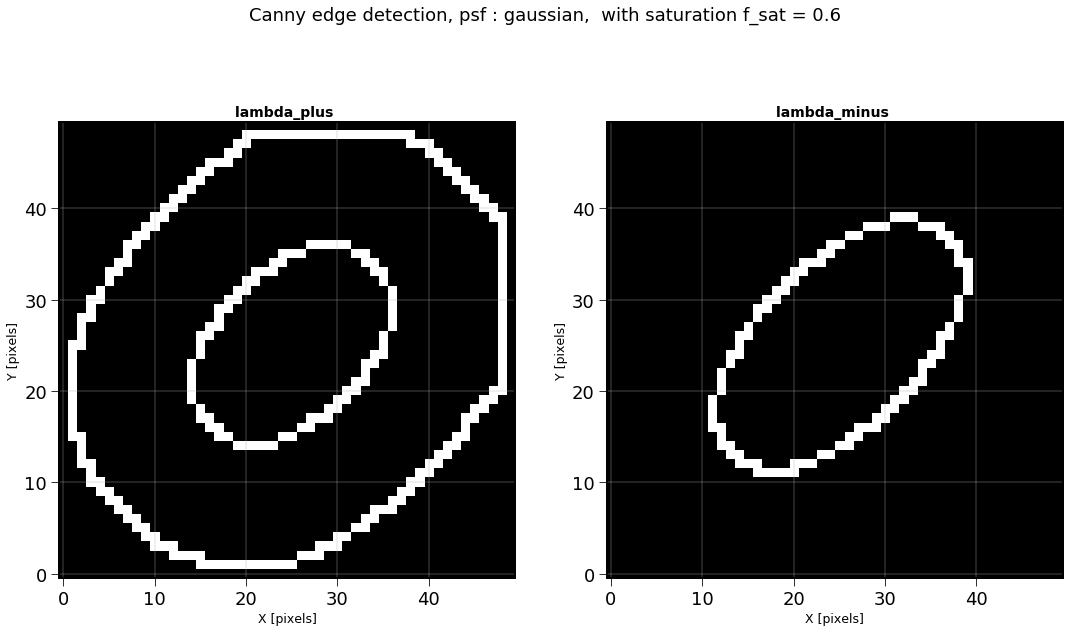

In [110]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_plus_edge, origin="lower", cmap=plt.cm.gray)
ax1.set_title('lambda_plus ', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2.imshow(lambda_minus_edge, origin="lower", cmap=plt.cm.gray)
ax2.set_title('lambda_minus ', fontsize=14)
ax2.grid(True)
ax2.set_xlabel('X [pixels]')
ax2.set_ylabel('Y [pixels]')
        
title="Canny edge detection, "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"    
    
# fig.tight_layout()
plt.suptitle(title,fontsize=18)

# Minimisation - Optimisation
https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

## Interpolation

In [111]:
f_img = interpolate.interp2d(XX, YY, image, kind='linear')

In [112]:
f_lambda_plus_plus = interpolate.interp2d(XX, YY, lambda_plus_new, kind='linear')

In [113]:
f_lambda_plus_moins = interpolate.interp2d(XX, YY, -lambda_plus_new, kind='linear')

In [114]:
f_lambda_minus_plus = interpolate.interp2d(XX, YY, lambda_minus_new, kind='linear')

In [115]:
f_lambda_minus_moins = interpolate.interp2d(XX, YY, -lambda_minus_new, kind='linear')

## Selection of array on which array is done the minimisation

In [116]:
title = "lambda_minus (plus)"
thelambdaarr= lambda_minus_new
def function_opt(x):
    return f_lambda_minus_plus(x[0],x[1])[0]

In [117]:
#title = "lambda_minus (moins)"
#thelambdaarr= -lambda_minus_new
#def function_opt(x):
#    return f_lambda_minus_moins(x[0],x[1])[0]

In [118]:
#title = "lambda_plus (plus)"
#thelambdaarr= lambda_plus_new
#def function_opt(x):
#    return f_lambda_plus_plus(x[0],x[1])[0]

In [119]:
#title = "lambda_plus (moins)"
#thelambdaarr= - lambda_plus_new
#def function_opt(x):
#    return f_lambda_plus_moins(x[0],x[1])[0]

In [120]:
if sat_fraction > 0:
    title= title + psf_title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + psf_title +" without saturation"  

## Test many optimisation algorithm:

Global optimization aims to find the global minimum of a function within given bounds, in the presence of potentially many local minima. Typically global minimizers efficiently search the parameter space, while using a local minimizer (e.g. minimize) under the hood. SciPy contains a number of good global optimizers. Here we’ll use those on the same objective function, namely the (aptly named) eggholder function:

- SHGO       : simplicial homology global optimization
- DA         : dual_annealing
- DE         : differential_evolution
- BH         : basinhopping
- SHGO_SOBOL : shgo has a second method, which returns all local minima rather than only what it thinks is the global minimum:

In [121]:
bounds = [(0, image.shape[1]), (0, image.shape[1])]

In [122]:
results = dict()
results['shgo'] = optimize.shgo(function_opt, bounds)

In [123]:
results['shgo']

     fun: -20.271287229523004
    funl: array([-20.27128723])
 message: 'Optimization terminated successfully.'
    nfev: 341
     nit: 2
   nlfev: 336
   nlhev: 0
   nljev: 35
 success: True
       x: array([25.40154528, 25.12614455])
      xl: array([[25.40154528, 25.12614455]])

In [124]:
results['DA'] = optimize.dual_annealing(function_opt, bounds)

In [125]:
results['DA']

     fun: -22.14266827688395
 message: ['Maximum number of iteration reached']
    nfev: 4793
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([25.40154528, 23.65613954])

In [126]:
results['DE'] = optimize.differential_evolution(function_opt, bounds)

In [127]:
results['DE']

     fun: -22.142665206714632
     jac: array([-43.98986455,   2.60986646])
 message: 'Optimization terminated successfully.'
    nfev: 1008
     nit: 26
 success: True
       x: array([25.40154523, 23.65613986])

In [128]:
results['BH'] = optimize.basinhopping(function_opt, bounds)

In [129]:
results['BH']

                        fun: -1.2333362256954898
 lowest_optimization_result:       fun: -1.2333362256954898
 hess_inv: array([[ 1.06593255e-08, -8.54819605e-10,  0.00000000e+00,
         0.00000000e+00],
       [-8.54819605e-10,  2.23773974e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
      jac: array([-0.24369811,  0.03548342,  0.        ,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 948
      nit: 3
     njev: 156
   status: 2
  success: False
        x: array([ 1.44330084, 47.00248047, -3.67704908, 51.81888487])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 14
                       nfev: 7734
                        nit: 100
                       njev: 1272
                

In [130]:
results['shgo_sobol'] = optimize.shgo(function_opt, bounds, n=200, iters=5,sampling_method='sobol')

In [131]:
results['shgo_sobol'] 

     fun: -22.14266824696542
    funl: array([-22.14266825, -22.14266824, -20.24301777, -15.98029256,
       -15.98029252, -15.98029251, -11.82927894, -11.829276  ,
        -9.59617406,  -8.86264362,  -8.78532627,  -8.7783619 ,
        -8.71214478,  -1.42781864,  -1.42781862,  -1.2608241 ,
        -1.23333623,  -1.23333623,  -0.98006808,  -0.98006808,
        -0.98006808,  -0.98006808,  -0.98006808,  -0.87515883,
        -0.87515883,  -0.87515883,  -0.80364388])
 message: 'Optimization terminated successfully.'
    nfev: 8580
     nit: 5
   nlfev: 7580
   nlhev: 0
   nljev: 1110
 success: True
       x: array([25.40154528, 23.65613954])
      xl: array([[25.40154528, 23.65613954],
       [25.40154528, 23.65613954],
       [26.28367052, 32.52239275],
       [27.73784899, 23.65613954],
       [27.73784899, 23.65613954],
       [27.73784899, 23.65613954],
       [26.28367053, 18.73765629],
       [26.28367053, 18.73754567],
       [21.37577493, 27.99155421],
       [17.74990949, 23.656139

## Plot the results

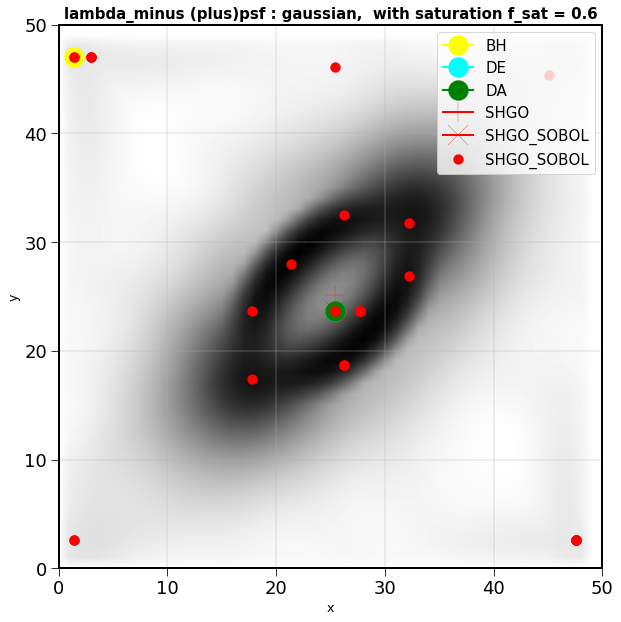

In [132]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(thelambdaarr, interpolation='bilinear', origin='lower',cmap='gray')

ax.set_xlabel('x')
ax.set_ylabel('y')

def plot_point(res, marker='o', color=None, ms=20,label=" "):
    ax.plot(res.x[0], res.x[1], marker=marker, color=color, ms=ms,label=label)

plot_point(results['BH'], color='yellow', label="BH")  # basinhopping           - yellow
plot_point(results['DE'], color='cyan', label="DE")  # differential_evolution - cyan
plot_point(results['DA'], color='green', label="DA")  # dual_annealing.        - white

# SHGO produces multiple minima, plot them all (with a smaller marker size)
plot_point(results['shgo'], color='r', marker='+',ms=20,label="SHGO")
plot_point(results['shgo_sobol'], color='r', marker='x',ms=20,label="SHGO_SOBOL")
for i in range(results['shgo_sobol'].xl.shape[0]):
    if i==0:     
        ax.plot(results['shgo_sobol'].xl[i, 0],results['shgo_sobol'].xl[i, 1],'ro', ms=10,label="SHGO_SOBOL")
    else:
        ax.plot(results['shgo_sobol'].xl[i, 0],results['shgo_sobol'].xl[i, 1],'ro', ms=10)

ax.set_xlim([0, image.shape[1]])
ax.set_ylim([0, image.shape[0]])
ax.legend(loc="upper right")  
ax.grid()
plt.title(title)
plt.show()